In [1]:
import os
import numpy as np

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras import layers, callbacks

from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix

import matplotlib.pyplot as plt

In [2]:
# 제스처 좌표데이터셋 목록 읽어오기
file_list = os.listdir("./Dataset")
# 파일 확장자 빼고 제스처 이름만 저장
actions = []
for i in range(len(file_list)) :
    actions.append(file_list[i][:-4])


# 회전변환 행렬
def Rx(theta) :
    return np.array([[1,        0,              0      ], 
                    [ 0,  np.cos(theta), -np.sin(theta)], 
                    [ 0,  np.sin(theta),  np.cos(theta)]])
def Ry(theta) :
    return np.array([[np.cos(theta),  0,  np.sin(theta)], 
                    [       0,        1,        0      ],
                    [-np.sin(theta),  0,  np.cos(theta)]])
def Rz(theta) :
    return np.array([[np.cos(theta), -np.sin(theta),  0  ], 
                    [ np.sin(theta),  np.cos(theta),  0  ], 
                    [       0,              0,        1  ]])
# 각 축을 기준으로 회전변환할 각도 (x, y, z 축 기준 회전각 : pitch, yaw, roll)
rotation_degree_x = np.deg2rad([0, 5,10,20,30, 355,350,340,330])
rotation_degree_y = np.deg2rad([0, 5,10,20,30, 355,350,340,330])
rotation_degree_z = np.deg2rad([0, 30,60,90,120,150,180,210,240,270,300,330])


# 시퀀스 길이
seq_length = 15

In [33]:
data_X = np.zeros((1, seq_length, 25))    # 25는 angle데이터 길이
data_Y = np.zeros(1)

# 각 제스처 좌표 데이터셋마다
for action_index, action_name in enumerate(actions):
    loaded = np.load(f'./Dataset/{actions[action_index]}.npy')

    # 각 회전마다
    for rdz in rotation_degree_z :
        for rdy in rotation_degree_y :
            for rdx in rotation_degree_x :
                
                data_list_X, data_list_y = [], []
                angle_data = []
                
                # 제스처데이터 각 프레임마다
                for fr in range(len(loaded)) :
                    coord = []
                    
                    # 각 프레임의 모든 랜드마크 좌표 회전변환
                    for lm in range(21) :    
                        coord.append( loaded[fr][lm] @ Rz(rdz) @ Ry(rdy) @ Rx(rdx) )
                    coord = np.array(coord)

                    a = coord[[ 5,  1,2,3,  5,6,7,   9,10,11,  13,14,15,  17,18,19,  0, 0], :]
                    b = coord[[17,  2,3,4,  6,7,8,  10,11,12,  14,15,16,  18,19,20,  5,17], :]
                    vec = b - a
                    vec_unit = vec / np.linalg.norm(vec, axis=1)[:, np.newaxis]
                    vec_unit = np.append(vec_unit, [[1,0,0]], axis=0)
                    
                    angle = np.arccos( np.einsum('ij, ij->i',
                        vec_unit[[0,1,2,  0,4,5,  0,7,8,   0,10,11,   0,13,14,  3,6,9,12,15,  6,9,12,15,  0], :],
                        vec_unit[[1,2,3,  4,5,6,  7,8,9,  10,11,12,  13,14,15,  0,0,0, 0, 0,  2,2, 2, 2,  18], :]))
                    angle_data.append(np.degrees(angle))
                
                # 시퀀스길이에 따라 시퀀스데이터로 변환
                for i in range(len(angle_data) - seq_length):
                    data_list_X.append(angle_data[i: i + seq_length])
                    data_list_y.append(action_index)

                # 문제지, 정답지
                data_X = np.append(data_X, data_list_X, axis=0)
                data_Y = np.append(data_Y, data_list_y, axis=0)

In [34]:
X = data_X[1:]
Y = data_Y[1:]

In [35]:
Y = to_categorical(Y, num_classes=len(actions))

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [37]:
model1 = Sequential([
    layers.GRU(48, input_shape = X_train.shape[1:], activation='tanh'),
    layers.Dense(24, activation='relu'),
    layers.Dense(len(actions), activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 48)                10800     
                                                                 
 dense_3 (Dense)             (None, 24)                1176      
                                                                 
 dense_4 (Dense)             (None, 4)                 100       
                                                                 
Total params: 12,076
Trainable params: 12,076
Non-trainable params: 0
_________________________________________________________________


In [38]:
model = Sequential([
    layers.GRU(24, input_shape = X_train.shape[1:], activation='tanh'),
    layers.Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 24)                3672      
                                                                 
 dense_5 (Dense)             (None, 4)                 100       
                                                                 
Total params: 3,772
Trainable params: 3,772
Non-trainable params: 0
_________________________________________________________________


In [39]:
epochs = 20
checkpoint = callbacks.ModelCheckpoint('./Models/model.h5', monitor='val_loss', save_best_only=True)
earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(   X_train, Y_train,
                    validation_split=0.25,
                    epochs = epochs,
                    callbacks = [checkpoint, earlystopping],
                    verbose=1   )

Epoch 1/20
821/821 [==============================] - 5s 4ms/step - loss: 0.3697 - accuracy: 0.9490 - val_loss: 0.1427 - val_accuracy: 1.0000
Epoch 2/20
821/821 [==============================] - 3s 4ms/step - loss: 0.0929 - accuracy: 1.0000 - val_loss: 0.0588 - val_accuracy: 1.0000
Epoch 3/20
821/821 [==============================] - 3s 4ms/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 1.0000
Epoch 4/20
821/821 [==============================] - 3s 4ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 5/20
821/821 [==============================] - 3s 4ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 6/20
821/821 [==============================] - 3s 4ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/20
821/821 [==============================] - 3s 4ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 

In [40]:
score = model.evaluate(X_test, Y_test)

274/274 [==============================] - 0s 1ms/step - loss: 8.7533e-06 - accuracy: 1.0000


### 학습 그래프

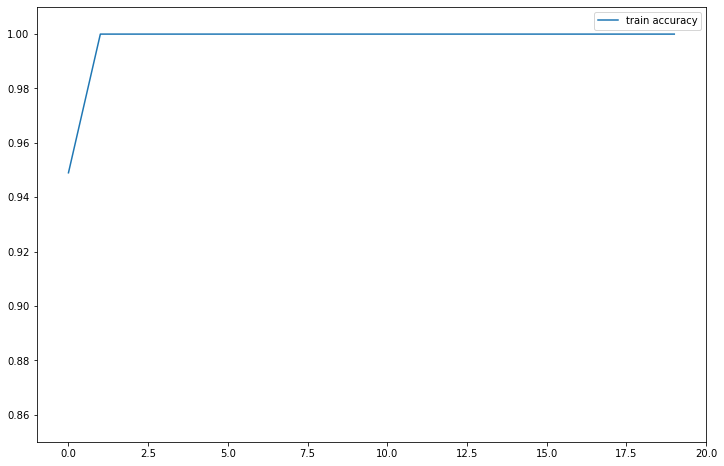

In [41]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'], label='train accuracy')

plt.xlim(-1,20)
plt.ylim(0.85,1.01)

plt.legend(), plt.grid
plt.show()

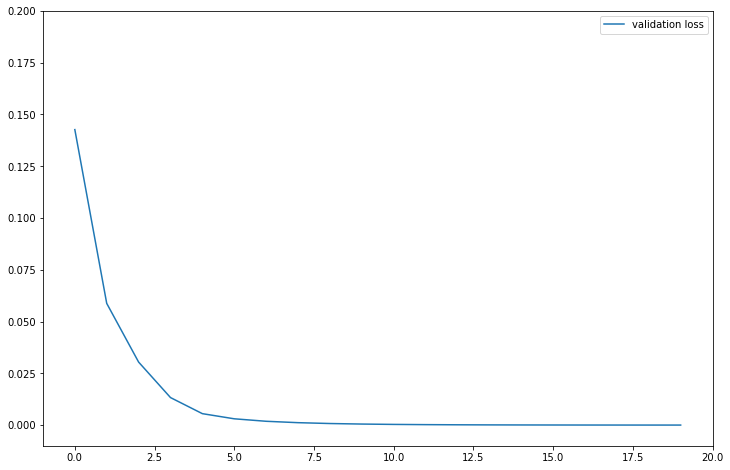

In [42]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_loss'], label='validation loss')

plt.xlim(-1,20)
plt.ylim(-0.01, 0.2)

plt.legend(), plt.grid
plt.show()

### 모델 평가

In [43]:
model = load_model('models/model.h5')

Y_pred = model.predict(X_test)
Y_pred

array([[1.3191927e-06, 3.3940034e-06, 9.9998832e-01, 6.9588646e-06],
       [9.9999499e-01, 9.2181537e-08, 3.8330468e-06, 1.0621465e-06],
       [1.8156555e-06, 2.8429449e-06, 6.0694679e-06, 9.9998927e-01],
       ...,
       [1.8156832e-06, 2.8429477e-06, 6.0696007e-06, 9.9998927e-01],
       [1.1402499e-06, 9.9998868e-01, 4.3883379e-06, 5.8028345e-06],
       [1.1401694e-06, 9.9998868e-01, 4.3881073e-06, 5.8025798e-06]],
      dtype=float32)

In [44]:
multilabel_confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

array([[[6810,    0],
        [   0, 1938]],

       [[6682,    0],
        [   0, 2066]],

       [[6367,    0],
        [   0, 2381]],

       [[6385,    0],
        [   0, 2363]]], dtype=int64)